IST - DBM2

# Data mining Project: : Titanic disaster Analysis

## Chad Long & Francesca Costa



The goal of this project is to analyse a dataset about the Titanic disaster with some methods and techniques studied in class.

This is the dataset that we used:
https://www.kaggle.com/competitions/titanic

Let's start  by presenting the data:

In [30]:
import pandas as pd
import csv
%matplotlib
#from scipy.stats import chi2_contingency
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

Using matplotlib backend: MacOSX


In [31]:
data = pd.read_csv('/Users/Francesca/Desktop/titanic1/train.csv')
data.columns = ['PassengerID', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 
               'Ticket', 'Fare', 'Cabin', 'Embarked']

data.head(10)


,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Data preprocessing

First of all, we want to check if there're some duplicated rows (and delete them in case).

In [32]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


There are no duplicated rows, so we can procede.


We want to look in more details at the number of tuples and attributes; our attention is focused on the presence of missing values.

In [33]:
print('Number of instances = %d' % data.shape[0])
print('Number of attributes = %d' % data.shape[1])

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col, data[col].isna().sum()))

Number of instances = 891
Number of attributes = 12
Number of missing values:
	PassengerID: 0
	Survived: 0
	Pclass: 0
	Name: 0
	Sex: 0
	Age: 177
	SibSp: 0
	Parch: 0
	Ticket: 0
	Fare: 0
	Cabin: 687
	Embarked: 2


As we can see, in our dataset there are 891 istances and 12 attributes. However, not all columns are really needed for our analysis and we want to drop them.
In this first step we will delete:
- PassegnerID
- Name
- Ticket

In [34]:
dataShort = data.drop(['PassengerID','Name', 'Ticket'],axis=1)

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


We noticed that 3 columns present some missing values:
- Age
- Cabin
- Embarked

In [35]:
total = dataShort.isnull().sum().sort_values(ascending=False)
percent_1 = dataShort.isnull().sum()/dataShort.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(3)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


The column 'Cabin' presents lots of missing values (77% of the total). We decided to drop it.

In [36]:
dataShort = dataShort.drop(['Cabin'],axis=1)

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Then, in order to fill 'Age' missing values, we decided to replace NaN with the female average age for female passengers and the male average age for male passengers (rounded).

In [37]:
women = dataShort[dataShort['Sex']=='female']
women_avgAge = round(women["Age"].mean())
print('Women average age = %d' % women_avgAge)

men = dataShort[dataShort['Sex']=='male']
men_avgAge = round(men["Age"].mean())
print('Men average age = %d' % men_avgAge)

Women average age = 28
Men average age = 31


In [38]:
dataShort.loc[(dataShort.Sex =='female') & (dataShort.Age.isnull()), 'Age'] = women_avgAge
dataShort.loc[(dataShort.Sex == 'male') & (dataShort.Age.isnull()), 'Age'] = men_avgAge

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Instead of using only the average age, it would have been interesting also considering the presence of children, parents, wife/husband in order to stimate the missing age value.
However, the dataset provides information about siblings-spose, parents-children combined together; this makes our idea unfeasible.

The column 'Embarked' has only 2 missing values. Counting the different values we obtain:

In [39]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We decided to fill those missing two values with the most probable value S (Southampton).

In [40]:
dataShort.loc[dataShort.Embarked.isnull(), 'Embarked'] = 'S'

Let's check the number of missing values now:

In [41]:
print('Number of instances = %d' % dataShort.shape[0])
print('Number of attributes = %d' % dataShort.shape[1])

print('Number of missing values:')
for col in dataShort.columns:
    print('\t%s: %d' % (col, dataShort[col].isna().sum()))

Number of instances = 891
Number of attributes = 8
Number of missing values:
	Survived: 0
	Pclass: 0
	Sex: 0
	Age: 0
	SibSp: 0
	Parch: 0
	Fare: 0
	Embarked: 0


In [25]:
dataShort.to_csv('cleaned_data.csv', index = False)

Now that we've cleaned and tidied our dataset, let's procede in our analysis.

## Frequent pattern mining

Looking at the dataset, we came out with some assumptions about the relationship between the attributes. For example:
- the higher the class (lower number), the higher the price
- people from the upper class could obtain a lifeboat more easily
- women were the first to be rescued

We compute the correlation matrix to study the relationship between all the attributes.
In order to do that, we considered only the numerical attributes (we converted 'Sex' binary attribute into 0 for men and 1 for women).

In [42]:
rep = {"male": 0, "female": 1}
dataShort.replace({'Sex' : rep}, inplace=True)

print("The correlation matrix is: \n")

corr = dataShort.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')


The correlation matrix is: 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.081736,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.329201,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.104850,0.114631,0.245489,0.182333
Age,-0.081736,-0.329201,-0.104850,1.000000,-0.237059,-0.183536,0.088270
SibSp,-0.035322,0.083081,0.114631,-0.237059,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.183536,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.088270,0.159651,0.216225,1.000000


As we predicted, Fare and Pclass are negatively correlated; indeed, the lower in the number that identifies the class (1 for the first class), the higher is the price of the ticket.

From the correlation matrix we can notice that sex and survival are highly correlated.

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


rep = {0: "male", 1: "female"}
dataShort.replace({'Sex' : rep}, inplace=True)

sns.set(style="whitegrid")
ax = sns.countplot(y='Sex', hue="Survived", data=dataShort)
plt.ylabel('Sex')
plt.title('Survival Plot')
plt.show()

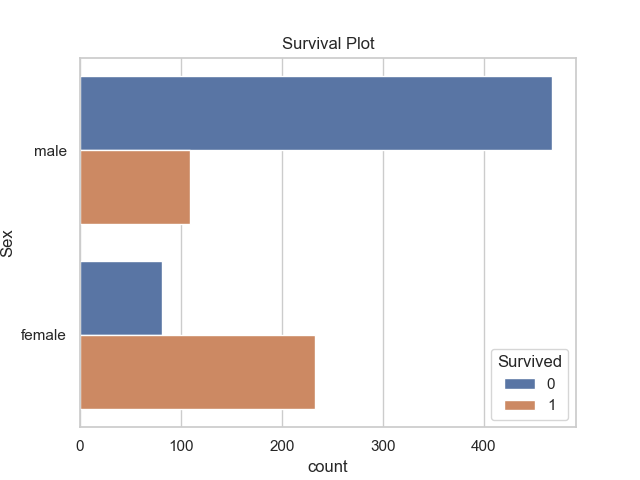

We can see that most of the survivals are women, even if the vast maggiority of passengers consists of men. The two attributes are positively correlated (they grow togheter); indeed, survival is identified with number 1 (death with 0), females with number 1 (males 0).

We want also to show the correlation between the first class and the survival.

In [45]:
firstClass_survived = ((dataShort['Pclass'] == 1) & (dataShort['Survived']== 1)).sum()
firstClass_notSurvived = ((dataShort['Pclass'] == 1) & (dataShort['Survived']== 0)).sum()
otherClass_survived = ((dataShort['Pclass'] != 1) & (dataShort['Survived'] == 1)).sum()
otherClass_notSurvived = ((dataShort['Pclass'] != 1) & (dataShort['Survived'] == 0)).sum()

firstClass_total = (dataShort['Pclass'] == 1).sum()
otherClass_total = (dataShort['Pclass'] != 1).sum()
survived_total = (dataShort['Survived'] == 1).sum()
notSurvived_total = (dataShort['Survived'] == 0).sum()
total = survived_total + notSurvived_total

print('First class survived: ', firstClass_survived)
print('First class not survived: ', firstClass_notSurvived)
print('Other classes survived: ', otherClass_survived)
print('Other classes not survived: ', otherClass_notSurvived)
print('\nFirst class total: ', firstClass_total)
print('Other classes total: ', otherClass_total)
print('Survived total: ', survived_total)
print('Not survived total: ', notSurvived_total)
print('\nTotal sum: ', total)

First class survived:  136
First class not survived:  80
Other classes survived:  206
Other classes not survived:  469

First class total:  216
Other classes total:  675
Survived total:  342
Not survived total:  549

Total sum:  891


In [46]:
table = pd.DataFrame(
    [
        [136, 80, 216],
        [206, 469, 675],
        [342, 549, 891]
    ],
    index=["First class","Other classes", "Sum"],
    columns=["Survived","Not survived","Sum"])
table

,Survived,Not survived,Sum
First class,136,80,216
Other classes,206,469,675
Sum,342,549,891


We calculate the lift between first class and survivals.

In [47]:
firstClass_survived_probability = firstClass_survived / total
firstClass_probability = firstClass_total / total
survived_probability = survived_total / total

lift_firstSurvived = firstClass_survived_probability / (firstClass_probability*survived_probability)
print("The lift is: ", round(lift_firstSurvived, 2))

The lift is:  1.64


The lift value is > 1: it means that being in the first class and the survival are positively correlated

Albero decisionale: fai diverse prove con diversi alberi decisionali con diverse feature in input per evitare l'overfitting
Non testare l'argoritmo solo su un dataset completo, ma provare varie features per verificare l'overfitting
Valutare la bontà dell'algoritmo con tutti i parametri della classificazione.
Valutare le metriche sempre sul test set
overfitting = all'algoritmo passi troppi parametri e l'argoritmo impara a memoria.
Non identifica l'andamento generico dei dati. Non è rappresentativo della varietà dei dati, ma solo dei dati già osservati
Accuratezza non è fiducia
- vuoi evitare falsi negative
- sbilanciato
Considerare anche recall e la precision
Modello stupido che considera solo la possibilità più alta.

Random forest
Grafico rispetto alla profondità del grafico e valutare l'overfitting

We want to perform the Apriori algorithm in order to find frequent itemsets.
We decided to discretize the 'Age' attribute and divide it in categories:
- Child for Age <= 12
- Teen for 12 < Age <= 20
- Adult for 20 < Age <= 60
- Old for Age > 60

To make things simpler and easier to understand, we will consider only 'Survived', 'Pclass', 'Sex', 'Age', 'Embarked' as attributes in this step.

In [48]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [49]:
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  break_points = [minval] + cut_points + [maxval]
  if not labels:
    labels = range(len(cut_points)+1)
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

cut_points = [12, 20, 60 ]
labels = ["Child", "Teen", "Adult", "Old"]
dataShort['Age'] = binning(dataShort['Age'], cut_points, labels)

In [50]:
dataShort.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,Adult,1,0,7.2500,S
1,1,1,female,Adult,1,0,71.2833,C
2,1,3,female,Adult,0,0,7.9250,S
3,1,1,female,Adult,1,0,53.1000,S
4,0,3,male,Adult,0,0,8.0500,S
5,0,3,male,Adult,0,0,8.4583,Q
6,0,1,male,Adult,0,0,51.8625,S
7,0,3,male,Child,3,1,21.0750,S
8,1,3,female,Adult,0,2,11.1333,S
9,1,2,female,Teen,1,0,30.0708,C


In [51]:
data_ap = dataShort.drop(['SibSp', 'Parch', 'Fare'], axis = 1)

data_ap.head()

,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,Adult,S
1,1,1,female,Adult,C
2,1,3,female,Adult,S
3,1,1,female,Adult,S
4,0,3,male,Adult,S


We dediced to rename some attributes to make the next steps clearer.

In [52]:
rep = {1: "Survived", 0: "Not survived"}
data_ap.replace({'Survived' : rep}, inplace=True)

rep = {"S": "Southampton", "C": "Cherbourg", "Q":"Queenstown"}
data_ap.replace({'Embarked' : rep}, inplace=True)

rep = {1: "First class", 2: "Second class", 3:"Third class"}
data_ap.replace({'Pclass' : rep}, inplace=True)

rep = {1: "male", 2: "female"}
data_ap.replace({'Sex' : rep}, inplace=True)

data_ap.head()

,Survived,Pclass,Sex,Age,Embarked
0,Not survived,Third class,male,Adult,Southampton
1,Survived,First class,female,Adult,Cherbourg
2,Survived,Third class,female,Adult,Southampton
3,Survived,First class,female,Adult,Southampton
4,Not survived,Third class,male,Adult,Southampton


In [53]:
dataset = []


for i in range(0, data_ap.shape[0]):
    dataset.append([str(data_ap.values[i,j]) for j in range(0, data_ap.shape[1])])

oht = TransactionEncoder()
oht_ary = oht.fit(dataset).transform(dataset)
df = pd.DataFrame(oht_ary, columns=oht.columns_)
df

,Adult,Cherbourg,Child,First class,Not survived,Old,Queenstown,Second class,Southampton,Survived,Teen,Third class,female,male
0,True,False,False,False,True,False,False,False,True,False,False,True,False,True
1,True,True,False,True,False,False,False,False,False,True,False,False,True,False
2,True,False,False,False,False,False,False,False,True,True,False,True,True,False
3,True,False,False,True,False,False,False,False,True,True,False,False,True,False
4,True,False,False,False,True,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,True,False,False,False,True,False,False,True,True,False,False,False,False,True
887,False,False,False,True,False,False,False,False,True,True,True,False,True,False
888,True,False,False,False,True,False,False,False,True,False,False,True,True,False
889,True,True,False,True,False,False,False,False,False,True,False,False,False,True


We perfom Apriori algorithm:

In [54]:
frq_items = apriori(df, min_support = 0.2, use_colnames = True)

rules = association_rules(frq_items, metric = "lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending = [False, False])

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
94,"(Adult, male, Third class)",(Not survived),0.299663,0.616162,0.263749,0.880150,1.428440,0.079108,3.202652
121,"(male, Third class, Southampton)",(Not survived),0.297419,0.616162,0.259259,0.871698,1.414723,0.076001,2.991682
28,"(Adult, Not survived)",(male),0.488215,0.647587,0.424242,0.868966,1.341851,0.108080,2.689468
79,"(Adult, Not survived, Southampton)",(male),0.373737,0.647587,0.324355,0.867868,1.340156,0.082327,2.667126
56,"(male, Third class)",(Not survived),0.389450,0.616162,0.336700,0.864553,1.403128,0.096736,2.833871
10,(Not survived),(male),0.616162,0.647587,0.525253,0.852459,1.316362,0.126234,2.388577
49,"(Not survived, Southampton)",(male),0.479237,0.647587,0.408530,0.852459,1.316362,0.098182,2.388577
80,"(Adult, male, Southampton)",(Not survived),0.382716,0.616162,0.324355,0.847507,1.375463,0.088540,2.517094
1,(First class),(Adult),0.242424,0.774411,0.203143,0.837963,1.082065,0.015407,1.392208
68,"(Adult, Third class, Southampton)",(Not survived),0.289562,0.616162,0.240180,0.829457,1.346169,0.061762,2.250689


Looking at the rows with higher values for confidence and lift, we can state that adult male passengers from the third class were likely not to survive; probably they didn't have priority on lifeboats with respect to the upper classes and women. Also passengers embarked in Southampton were likely not to survive; we supposed that their cabins were far from the lifeboats.

## Classification

Our goal is to create a model that predicts the value of the "Survived" attribute by learning simple decision rules inferred from the data features. 
We decided to apply and optimize a Decision Tree Classifier.

- Decision trees
- Finding best tree depth with the help of Cross Validation
- Random forest

In [58]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [84]:
train, test = train_test_split(dataShort, test_size = 0.2)

In [85]:
rep = {"male": 0, "female": 1}
train.replace({"Sex" : rep}, inplace=True)
test.replace({"Sex" : rep}, inplace=True)

rep = {"Child": 0, "Teen": 1, "Adult": 2, "Old": 3}
train.replace({"Age" : rep}, inplace=True)
test.replace({"Age" : rep}, inplace=True)

train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
812,0,2,0,2,0,0,10.5000,S
437,1,2,1,2,2,3,18.7500,S
458,1,2,1,2,0,0,10.5000,S
147,0,3,1,0,2,2,34.3750,S
52,1,1,1,2,1,0,76.7292,C
...,...,...,...,...,...,...,...,...
351,0,1,0,2,0,0,35.0000,S
84,1,2,1,1,0,0,10.5000,S
620,0,3,0,2,1,0,14.4542,C
735,0,3,0,2,0,0,16.1000,S


In [86]:
one_hot = pd.get_dummies(train['Embarked'])

train = train.drop('Embarked', axis = 1)
train = train.join(one_hot)

train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
812,0,2,0,2,0,0,10.5000,0,0,1
437,1,2,1,2,2,3,18.7500,0,0,1
458,1,2,1,2,0,0,10.5000,0,0,1
147,0,3,1,0,2,2,34.3750,0,0,1
52,1,1,1,2,1,0,76.7292,1,0,0
...,...,...,...,...,...,...,...,...,...,...
351,0,1,0,2,0,0,35.0000,0,0,1
84,1,2,1,1,0,0,10.5000,0,0,1
620,0,3,0,2,1,0,14.4542,1,0,0
735,0,3,0,2,0,0,16.1000,0,0,1


In [87]:
one_hot = pd.get_dummies(test['Embarked'])

test = test.drop('Embarked', axis = 1)
test = test.join(one_hot)

test

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
558,1,1,1,2,1,1,79.6500,0,0,1
543,1,2,0,2,1,0,26.0000,0,0,1
438,0,1,0,3,1,4,263.0000,0,0,1
873,0,3,0,2,0,0,9.0000,0,0,1
342,0,2,0,2,0,0,13.0000,0,0,1
590,0,3,0,2,0,0,7.1250,0,0,1
114,0,3,1,1,0,0,14.4583,1,0,0
825,0,3,0,2,0,0,6.9500,0,1,0
879,1,1,1,2,0,1,83.1583,1,0,0
402,0,3,1,2,1,0,9.8250,0,0,1


In [82]:
Y = train['Survived']
X = train.drop(['Survived'], axis = 1)

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
clf = clf.fit(X,Y)

tree.plot_tree(clf)

[Text(0.5, 0.875, 'X[1] <= 0.5\nentropy = 0.978\nsamples = 712\nvalue = [418, 294]'),
 Text(0.25, 0.625, 'X[5] <= 26.269\nentropy = 0.736\nsamples = 444\nvalue = [352, 92]'),
 Text(0.125, 0.375, 'X[2] <= 13.5\nentropy = 0.587\nsamples = 326\nvalue = [280, 46]'),
 Text(0.0625, 0.125, 'entropy = 0.414\nsamples = 12\nvalue = [1, 11]'),
 Text(0.1875, 0.125, 'entropy = 0.504\nsamples = 314\nvalue = [279, 35]'),
 Text(0.375, 0.375, 'X[3] <= 2.5\nentropy = 0.965\nsamples = 118\nvalue = [72, 46]'),
 Text(0.3125, 0.125, 'entropy = 0.991\nsamples = 101\nvalue = [56, 45]'),
 Text(0.4375, 0.125, 'entropy = 0.323\nsamples = 17\nvalue = [16, 1]'),
 Text(0.75, 0.625, 'X[0] <= 2.5\nentropy = 0.805\nsamples = 268\nvalue = [66, 202]'),
 Text(0.625, 0.375, 'X[5] <= 28.856\nentropy = 0.306\nsamples = 146\nvalue = [8, 138]'),
 Text(0.5625, 0.125, 'entropy = 0.459\nsamples = 62\nvalue = [6, 56]'),
 Text(0.6875, 0.125, 'entropy = 0.162\nsamples = 84\nvalue = [2, 82]'),
 Text(0.875, 0.375, 'X[5] <= 24.808\nen

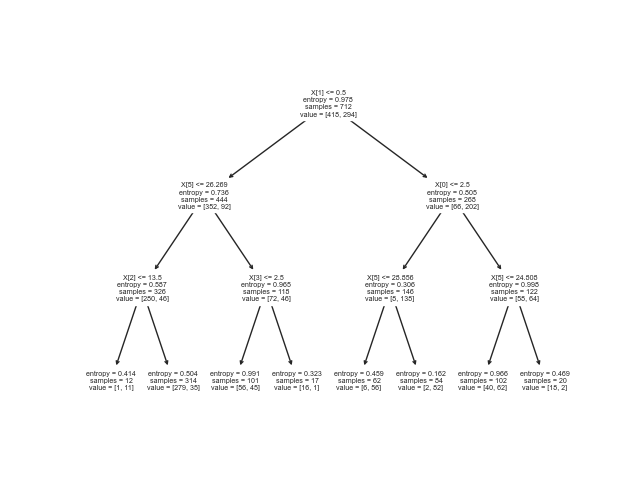

## Prove con gli hyperparameters

We want to find which set of hyperparameters will give us the best result.

In [59]:
#std_slc = StandardScaler()

In [75]:
dec_tree = tree.DecisionTreeClassifier()

In [76]:
#pipe = Pipeline(steps = [('std_slc', std_slc), ('dec_tree', dec_tree)])
pipe = Pipeline(steps = [('dec_tree', dec_tree)])

In [77]:
n_components = list(range(1, X.shape[1]+1, 1))

In [78]:
criterion = ['gini', 'entropy']
max_depth = [2,3,4,5,6,7,8,9,10]

In [79]:
parameters = dict(dec_tree__criterion = criterion, 
                  dec_tree__max_depth = max_depth)

In [80]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, Y)

GridSearchCV(estimator=Pipeline(steps=[('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [81]:
print("Best Criterion: ", clf_GS.best_estimator_.get_params() ['dec_tree__criterion'])
print("Best max_depth: ", clf_GS.best_estimator_.get_params() ['dec_tree__max_depth'])
print();
print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion:  gini
Best max_depth:  3

DecisionTreeClassifier(max_depth=3)
